In [1]:
pip install tensorflow numpy matplotlib pillow


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_images_from_folder(folder, image_size=(128, 128)):
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            img = img.resize(image_size)
            images.append(np.array(img))
    return np.array(images)

# Load images
folder_path = r'C:\Users\ishit\Downloads\archive (1)\fashion-pattern-images\graphic'
images = load_images_from_folder(folder_path)
images = images / 255.0  # Normalize images

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(images)


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout

# Generator model
def build_generator():
    model = tf.keras.Sequential()
    model.add(Dense(256*8*8, activation="relu", input_dim=100))
    model.add(Reshape((8, 8, 256)))
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation="tanh"))
    return model

# Discriminator model
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(Conv2D(64, kernel_size=4, strides=2, input_shape=(128, 128, 3), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout

# Generator model
def build_generator():
    model = tf.keras.Sequential()
    model.add(Dense(256*8*8, activation="relu", input_dim=100))
    model.add(Reshape((8, 8, 256)))
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(32, kernel_size=4, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation="tanh"))
    return model

# Discriminator model
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(Conv2D(64, kernel_size=4, strides=2, input_shape=(128, 128, 3), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

# Compile the models
def compile_gan(generator, discriminator):
    discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    discriminator.trainable = False

    gan_input = tf.keras.Input(shape=(100,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(optimizer='adam', loss='binary_crossentropy')

    # Set discriminator back to trainable
    discriminator.trainable = True

    return gan

# Training function
def train_gan(generator, discriminator, gan, images, epochs=10000, batch_size=32, save_interval=1000):
    for epoch in range(epochs):
        # Train discriminator
        idx = np.random.randint(0, images.shape[0], batch_size)
        real_images = images[idx]
        real_labels = np.ones((batch_size, 1))

        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_images = generator.predict(noise)
        fake_labels = np.zeros((batch_size, 1))

        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_labels = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, valid_labels)

        # Print progress
        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}%] [G loss: {g_loss}]")
            save_images(generator, epoch)

# Save generated images
def save_images(generator, epoch, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, (examples, 100))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5  # Rescale to [0, 1]

    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"generated_images_epoch_{epoch}.png")
    plt.close()

# Load and preprocess images
def load_images_from_folder(folder, image_size=(128, 128)):
    import os
    from PIL import Image
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            img = img.resize(image_size)
            images.append(np.array(img))
    return np.array(images)

# Specify the path to your dataset
folder_path = r'C:\Users\ishit\Downloads\archive (1)\fashion-pattern-images\graphic'  # Update this to your actual image folder path
images = load_images_from_folder(folder_path)
images = images / 255.0  # Normalize images

# Build and compile the models
generator = build_generator()
discriminator = build_discriminator()
gan = compile_gan(generator, discriminator)

# Train the GAN
train_gan(generator, discriminator, gan, images, epochs=100, batch_size=32, save_interval=1000)


C:\Users\ishit\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ishit\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
C:\Users\ishit\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
0 [D loss: 0.7198390364646912, acc.: 32.8125%] [G loss: [array(0.7181665, dtype=float32), array(0.7181665, dtype=float32), array(0.21875, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


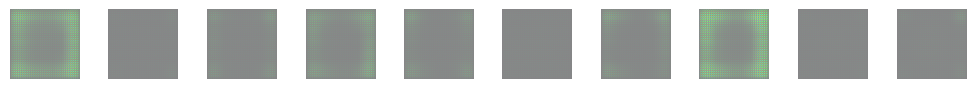

In [5]:
def generate_new_patterns(generator, examples=10):
    noise = np.random.normal(0, 1, (examples, 100))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5  # Rescale to [0, 1]

    plt.figure(figsize=(10, 1))
    for i in range(examples):
        plt.subplot(1, 10, i+1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Generate new patterns
generate_new_patterns(generator)
